# Кольцевое бета-распределение каршеринговых машин по Москве + заправки + экспорт датасета

Этот ноутбук:

1. Генерирует гладкое двумерное распределение каршеринговых машин вокруг центра Москвы
   с помощью бета-распределения по радиусу.
2. Назначает каждой машине уровень заправленности бака по заданному распределению:
   - < 10% бака — 1% парка
   - 10–20% — 3% парка
   - 20–50% — 20% парка
   - остальные машины считаются «заправленными» (> 50%).
3. Загружает датасет с координатами заправок.
4. Удаляет дубликаты заправок по координатам и оставляет только АЗС,
   находящиеся не дальше чем на 5 км от МКАД.
5. Визуализирует одновременно машины и заправки на карте Москвы.
6. Формирует датасеты машин (координаты + уровень заправленности) и сохраняет их в CSV.


In [18]:
!pip install scikit-optimize

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import cos
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

# -----------------------
# Конфигурация модели
# -----------------------

CONFIG = {
    "city": "Moscow",
    "random_seed": 42,
    # Центр Москвы (примерно Кремль)
    "city_center": {"lat": 55.7558, "lon": 37.6176},
    # Радиусы основных колец (км)
    "rings_km": {
        "sadovoe": 2.2,
        "ttk": 5.0,
        "mkad": 16.5,
    },
    # Минимальный радиус, внутри которого машин почти нет (запрет парковки)
    "min_radius_km": 1.0,
    # Максимальный радиус, до которого моделируем город (чуть дальше МКАД)
    "max_radius_km": 20.0,
    # Объем бака машины (л)
    "tank_volume_l": 50,
    # Варианты размеров парка
    "fleet_sizes": [500, 5000, 1500],
    # Распределение уровня заправленности (доля бака)
    # Вероятности задаются через поле share.
    "fuel_level_distribution": [
        {"range": [0.0, 0.1], "share": 0.01},  # < 10% бака — 1% парка
        {"range": [0.1, 0.2], "share": 0.03},  # 10–20% — 3% парка
        {"range": [0.2, 0.5], "share": 0.20},  # 20–50% — 20% парка
        # Остальные (1 - сумма share) будут иметь уровень [0.5, 1.0]
    ],
    # Радиальное распределение по времени суток (бета-распределение)
    "radial_beta_scenarios": {
        "morning": {
            # Пик между Садовым и ТТК, небольшой хвост к МКАД
            "alpha": 2.1,
            "beta": 4.0,
        },
        "evening": {
            # Более широкое распределение, больше массы ближе к МКАД
            "alpha": 5.0,
            "beta": 2.0,
        },
    },
}

np.random.seed(CONFIG["random_seed"])

In [20]:
from math import radians, sqrt

# ---- Вспомогательные функции для координат ----

def km_to_deg_lat(km: float) -> float:
    """Перевод километров в градусы широты (приблизительно)."""
    return km / 111.0

def km_to_deg_lon(km: float, lat_deg: float) -> float:
    """Перевод километров в градусы долготы (приблизительно)."""
    return km / (111.0 * np.cos(np.radians(lat_deg)))

def deg_to_km(center_lat, center_lon, lat, lon):
    """Грубая оценка расстояния в км от центра до точки (lat, lon)
    в проекции на плоскость."""
    dlat_km = (lat - center_lat) * 111.0
    dlon_km = (lon - center_lon) * 111.0 * np.cos(np.radians(center_lat))
    return np.sqrt(dlat_km**2 + dlon_km**2)

# ---- Радиальное бета-распределение ----

def sample_radii_beta(n_points, scenario_cfg, min_radius_km, max_radius_km):
    """Генерация радиусов r (км) из бета-распределения на [min_radius_km, max_radius_km]."""
    alpha = scenario_cfg["alpha"]
    beta = scenario_cfg["beta"]
    x = np.random.beta(alpha, beta, size=n_points)  # на [0, 1]
    r = min_radius_km + x * (max_radius_km - min_radius_km)
    return r

def sample_positions_beta_ring(center_lat, center_lon, n_points, scenario_name, config=CONFIG):
    """Генерируем точки:
    1. Сэмплим радиус r по бета-распределению.
    2. Сэмплим угол θ ~ U(0, 2π).
    3. Переводим (r, θ) в lat/lon.
    """
    scenario_cfg = config["radial_beta_scenarios"][scenario_name]
    min_r = config["min_radius_km"]
    max_r = config["max_radius_km"]

    # Радиусы и углы
    r_km = sample_radii_beta(n_points, scenario_cfg, min_r, max_r)
    theta = np.random.uniform(0.0, 2.0 * np.pi, size=n_points)

    # Декартовы смещения в км
    x_km = r_km * np.cos(theta)
    y_km = r_km * np.sin(theta)

    # Перевод в градусы
    lat_offsets_deg = km_to_deg_lat(y_km)
    lon_offsets_deg = km_to_deg_lon(x_km, center_lat)

    lats = center_lat + lat_offsets_deg
    lons = center_lon + lon_offsets_deg
    return lats, lons, r_km

def generate_positions(n_cars, scenario_name, config=CONFIG):
    """Позиции машин: бета-распределение по радиусу + равномерный угол."""
    center = config["city_center"]
    lats, lons, r_km = sample_positions_beta_ring(center["lat"], center["lon"], n_cars, scenario_name, config)
    return lats, lons, r_km

# ---- Уровни топлива ----

def generate_fuel_levels(n_cars, config=CONFIG):
    """Генерация уровня топлива (доля бака) и требуемого долива (л).

    Распределение:
    - < 10% бака — 1% парка
    - 10–20%     — 3% парка
    - 20–50%     — 20% парка
    - остальное  — [0.5, 1.0]
    """
    dist = config["fuel_level_distribution"]
    tank_volume = config["tank_volume_l"]

    shares = [item["share"] for item in dist]
    ranges = [item["range"] for item in dist]
    thresholds = np.cumsum(shares)

    fuel_levels = np.empty(n_cars)
    u = np.random.rand(n_cars)

    for i in range(n_cars):
        x = u[i]
        if x < thresholds[0]:
            low, high = ranges[0]
        elif x < thresholds[1]:
            low, high = ranges[1]
        elif x < thresholds[2]:
            low, high = ranges[2]
        else:
            low, high = 0.5, 1.0
        fuel_levels[i] = np.random.uniform(low, high)

    needed_liters = (1.0 - fuel_levels) * tank_volume
    need_refuel = fuel_levels < 0.5
    return fuel_levels, needed_liters, need_refuel

def simulate_fleet(n_cars, scenario_name, config=CONFIG):
    """Полная симуляция: позиции + топливо."""
    lats, lons, r_km = generate_positions(n_cars, scenario_name, config)
    fuel_levels, needed_liters, need_refuel = generate_fuel_levels(n_cars, config)

    df = pd.DataFrame({
        "car_id": np.arange(n_cars),
        "time_of_day": scenario_name,
        "lat": lats,
        "lon": lons,
        "radius_km": r_km,
        "fuel_level": fuel_levels,
        "needed_liters": needed_liters,
        "need_refuel": need_refuel,
    })
    return df

# ---- Окружности и карты ----

def circle_points(center_lat, center_lon, radius_km, num_points=360):
    """Координаты окружности радиуса radius_km вокруг центра."""
    angles = np.linspace(0, 2 * np.pi, num_points)
    x_km = radius_km * np.cos(angles)
    y_km = radius_km * np.sin(angles)

    lat_offsets_deg = km_to_deg_lat(y_km)
    lon_offsets_deg = km_to_deg_lon(x_km, center_lat)

    lats = center_lat + lat_offsets_deg
    lons = center_lon + lon_offsets_deg
    return lats, lons

def plot_map_with_rings_and_stations(df_cars, df_stations, title, config=CONFIG):
    """Карта с машинами, заправками и кольцами."""
    center = config["city_center"]
    rings = config["rings_km"]

    plt.figure(figsize=(6, 6))
    # Заправки
    plt.scatter(df_stations["lon"], df_stations["lat"], s=12, alpha=0.8, marker="^", label="АЗС")
    # Машины
    plt.scatter(df_cars["lon"], df_cars["lat"], s=3, alpha=0.3, label="Машины")

    sad_lats, sad_lons = circle_points(center["lat"], center["lon"], rings["sadovoe"])
    ttk_lats, ttk_lons = circle_points(center["lat"], center["lon"], rings["ttk"])
    mkad_lats, mkad_lons = circle_points(center["lat"], center["lon"], rings["mkad"])

    plt.plot(sad_lons, sad_lats, linewidth=1.5, label="Садовое кольцо")
    plt.plot(ttk_lons, ttk_lats, linewidth=1.5, label="ТТК")
    plt.plot(mkad_lons, mkad_lats, linewidth=1.5, label="МКАД")

    plt.scatter([center["lon"]], [center["lat"]], marker="x", s=80, label="Центр города")

    plt.xlabel("Долгота")
    plt.ylabel("Широта")
    plt.title(title)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

def plot_fuel_histogram(df, title):
    """Гистограмма распределения уровня топлива."""
    plt.figure(figsize=(6, 4))
    plt.hist(df["fuel_level"], bins=20)
    plt.xlabel("Уровень топлива (доля бака)")
    plt.ylabel("Количество машин")
    plt.title(title)
    plt.grid(True)
    plt.show()

def print_ring_stats(df, config=CONFIG):
    """Доля машин в диапазонах: до Садового, между Садовым и ТТК, между ТТК и МКАД, за МКАД."""
    rings = config["rings_km"]
    r = df["radius_km"].values

    sad = rings["sadovoe"]
    ttk = rings["ttk"]
    mkad = rings["mkad"]

    inner = r < sad
    sad_ttk = (r >= sad) & (r < ttk)
    ttk_mkad = (r >= ttk) & (r < mkad)
    outside = r >= mkad

    n = len(r)
    print(f"Всего машин: {n}")
    print(f"  Внутри Садового (< {sad} км): {inner.mean():.3f}")
    print(f"  Между Садовым и ТТК ([{sad}, {ttk}) км): {sad_ttk.mean():.3f}")
    print(f"  Между ТТК и МКАД ([{ttk}, {mkad}) км): {ttk_mkad.mean():.3f}")
    print(f"  За МКАД (>= {mkad} км): {outside.mean():.3f}")

In [21]:
# Загрузка датасета с заправками и фильтрация по расстоянию от МКАД

stations_csv_path = "moscow_stations.csv"  # путь поправь под себя, если нужно

df_stations_raw = pd.read_csv(stations_csv_path)
print("Всего записей в датасете заправок:", len(df_stations_raw))
print(df_stations_raw.head())

# Убираем дубликаты по координатам
df_stations = df_stations_raw.drop_duplicates(subset=["lat", "lon"]).copy()
print("Уникальных заправок по координатам до фильтрации:", len(df_stations))

# Радиус от центра для каждой заправки
center_lat = CONFIG["city_center"]["lat"]
center_lon = CONFIG["city_center"]["lon"]
mkad_r = CONFIG["rings_km"]["mkad"]
buffer_km = 5.0  # не дальше чем 5 км от МКАД

df_stations["radius_km"] = deg_to_km(center_lat, center_lon,
                                     df_stations["lat"].values,
                                     df_stations["lon"].values)

mask = df_stations["radius_km"] <= mkad_r + buffer_km
df_stations = df_stations[mask].copy()

print("АЗС после фильтрации (<= МКАД + 5 км):", len(df_stations))

Всего записей в датасете заправок: 1359
         lat        lon  price
0  54.936169  37.530037  60.01
1  55.886448  38.169321  67.80
2  54.936610  37.527840  60.01
3  55.875330  38.199880  60.34
4  55.450078  37.527992  59.90
Уникальных заправок по координатам до фильтрации: 1313
АЗС после фильтрации (<= МКАД + 5 км): 504


Симуляция для парка из 5000 машин

=== Утро ===
Всего машин: 5000
  Внутри Садового (< 2.2 км): 0.026
  Между Садовым и ТТК ([2.2, 5.0) км): 0.223
  Между ТТК и МКАД ([5.0, 16.5) км): 0.746
  За МКАД (>= 16.5 км): 0.006


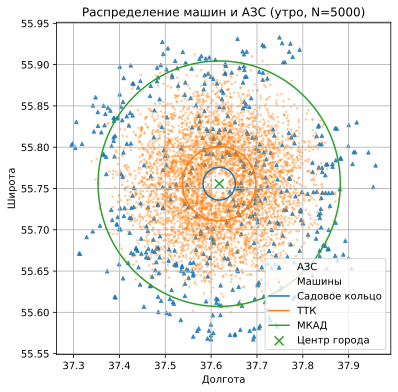

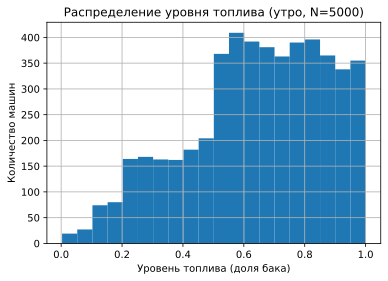


=== Вечер ===
Всего машин: 5000
  Внутри Садового (< 2.2 км): 0.000
  Между Садовым и ТТК ([2.2, 5.0) км): 0.002
  Между ТТК и МКАД ([5.0, 16.5) км): 0.682
  За МКАД (>= 16.5 км): 0.316


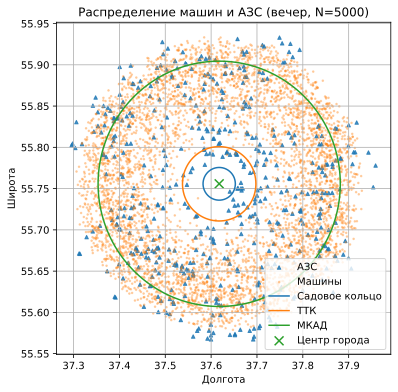

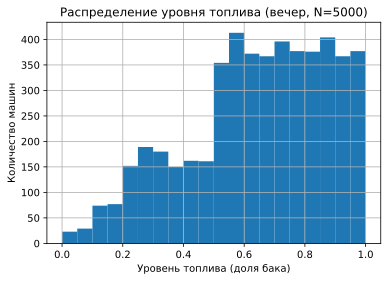

In [22]:
# Пример: парк 10 000 машин, утро и вечер + отфильтрованные заправки

fleet_size = CONFIG["fleet_sizes"][1]  # 10 000
print(f"Симуляция для парка из {fleet_size} машин")

df_morning = simulate_fleet(fleet_size, "morning", CONFIG)
df_evening = simulate_fleet(fleet_size, "evening", CONFIG)

print("\n=== Утро ===")
print_ring_stats(df_morning, CONFIG)
plot_map_with_rings_and_stations(df_morning, df_stations,
                                 f"Распределение машин и АЗС (утро, N={fleet_size})", CONFIG)
plot_fuel_histogram(df_morning, f"Распределение уровня топлива (утро, N={fleet_size})")

print("\n=== Вечер ===")
print_ring_stats(df_evening, CONFIG)
plot_map_with_rings_and_stations(df_evening, df_stations,
                                 f"Распределение машин и АЗС (вечер, N={fleet_size})", CONFIG)
plot_fuel_histogram(df_evening, f"Распределение уровня топлива (вечер, N={fleet_size})")

In [23]:
# Сохранение датасетов машин (координаты + уровень заправленности) в CSV

# Можно переопределить fleet_size выше и заново пересимулировать парк,
# тогда здесь просто сохраняем актуальные df_morning и df_evening.

cols = ["car_id", "time_of_day", "lat", "lon", "fuel_level", "needed_liters", "need_refuel"]

output_morning = "cars_morning_{}k.csv".format(fleet_size // 1000)
output_evening = "cars_evening_{}k.csv".format(fleet_size // 1000)

df_morning[cols].to_csv(output_morning, index=False)
df_evening[cols].to_csv(output_evening, index=False)

print("Сохранён файл с утренним парком:", output_morning)
print("Сохранён файл с вечерним парком:", output_evening)

Сохранён файл с утренним парком: cars_morning_5k.csv
Сохранён файл с вечерним парком: cars_evening_5k.csv


In [24]:
# Дополнительно: разные размеры парка и сценарии (без графиков, только статистика)

for fleet_size in CONFIG["fleet_sizes"]:
    print("\n==============================")
    print(f"Парк: {fleet_size} машин")
    for scenario in CONFIG["radial_beta_scenarios"].keys():
        print(f"\nСценарий: {scenario}")
        df = simulate_fleet(fleet_size, scenario, CONFIG)
        print_ring_stats(df, CONFIG)


Парк: 500 машин

Сценарий: morning
Всего машин: 500
  Внутри Садового (< 2.2 км): 0.022
  Между Садовым и ТТК ([2.2, 5.0) км): 0.244
  Между ТТК и МКАД ([5.0, 16.5) км): 0.728
  За МКАД (>= 16.5 км): 0.006

Сценарий: evening
Всего машин: 500
  Внутри Садового (< 2.2 км): 0.000
  Между Садовым и ТТК ([2.2, 5.0) км): 0.004
  Между ТТК и МКАД ([5.0, 16.5) км): 0.702
  За МКАД (>= 16.5 км): 0.294

Парк: 5000 машин

Сценарий: morning
Всего машин: 5000
  Внутри Садового (< 2.2 км): 0.032
  Между Садовым и ТТК ([2.2, 5.0) км): 0.233
  Между ТТК и МКАД ([5.0, 16.5) км): 0.728
  За МКАД (>= 16.5 км): 0.007

Сценарий: evening
Всего машин: 5000
  Внутри Садового (< 2.2 км): 0.000
  Между Садовым и ТТК ([2.2, 5.0) км): 0.003
  Между ТТК и МКАД ([5.0, 16.5) км): 0.688
  За МКАД (>= 16.5 км): 0.309

Парк: 1500 машин

Сценарий: morning
Всего машин: 1500
  Внутри Садового (< 2.2 км): 0.031
  Между Садовым и ТТК ([2.2, 5.0) км): 0.235
  Между ТТК и МКАД ([5.0, 16.5) км): 0.728
  За МКАД (>= 16.5 км): 

In [25]:
# === Взвешенный KNN-скор: релевантность машины j для заправки s ===
#
# Формула:
#   score_{s j} = (D_j / P_s) * f_dist(d_{s j}),
# где:
#   D_j  — needed_liters для машины j,
#   P_s  — цена топлива на заправке s,
#   d_{s j} — расстояние (в км) между станцией s и машиной j,
#   f_dist(d) = exp(-gamma * d)           (mode="exp")
#            или 1 / (d + eps)^p          (mode="power").
#
# Результат: матрица scores_df формы (S, N_need),
#   S       = число заправок,
#   N_need  = число машин, которым реально нужно топливо (needed_liters > 0).
# index    = идентификаторы станций,
# columns  = car_id.

import numpy as np
import pandas as pd

def latlon_distance_km(lat1, lon1, lat2, lon2):
    """Приближённое расстояние между точками (lat, lon) в километрах.
    Аргументы могут быть скалярами или numpy-массивами совместимых форм."""
    # 111 км на градус широты
    dlat_km = (lat2 - lat1) * 111.0
    # долгота -> км: умножаем на cos широты lat1
    dlon_km = (lon2 - lon1) * (111.0 * np.cos(np.radians(lat1)))
    return np.sqrt(dlat_km**2 + dlon_km**2)


def compute_station_car_scores(
    df_cars: pd.DataFrame,
    df_stations: pd.DataFrame,
    price_col: str,
    mode: str = "exp",      # "exp" или "power"
    gamma: float = 0.3,     # для mode="exp": f(d) = exp(-gamma * d)
    epsilon: float = 0.1,   # для mode="power": f(d) = 1 / (d + eps)^p
    p: float = 1.0,
    car_need_col: str = "needed_liters",
    car_id_col: str = "car_id",
    station_id_col: str = None,
):
    """Считает матрицу score_{s j} = (D_j / P_s) * f_dist(d_{s j}).

    df_cars:
        ожидается, что содержит столбцы:
          - car_id,
          - lat, lon,
          - needed_liters (>0 для машин, которым нужно топливо).
    df_stations:
        ожидается, что содержит:
          - lat, lon,
          - price_col с ценой топлива (руб/л),
          - опционально столбец station_id.
    """

    # Оставляем только машины, которым реально нужно топливо
    cars = df_cars.copy()
    if car_need_col not in cars.columns:
        raise ValueError(f"В df_cars нет столбца '{car_need_col}' с потребностью в литрах.")
    cars = cars[cars[car_need_col] > 0].copy()

    # Идентификаторы станций
    if station_id_col is not None and station_id_col in df_stations.columns:
        station_ids = df_stations[station_id_col].tolist()
    else:
        # Если явного ID нет — используем индекс
        station_ids = df_stations.index.to_list()

    car_ids = cars[car_id_col].tolist()

    # Координаты (S, 1) и (1, N)
    car_lat = cars["lat"].to_numpy()[None, :]         # (1, N)
    car_lon = cars["lon"].to_numpy()[None, :]         # (1, N)
    st_lat  = df_stations["lat"].to_numpy()[:, None]  # (S, 1)
    st_lon  = df_stations["lon"].to_numpy()[:, None]  # (S, 1)

    # Матрица расстояний d_{s j} (S, N)
    dist_km = latlon_distance_km(st_lat, st_lon, car_lat, car_lon)

    # f_dist(d)
    if mode == "exp":
        fdist = np.exp(-gamma * dist_km)
    elif mode == "power":
        fdist = 1.0 / np.power(dist_km + epsilon, p)
    else:
        raise ValueError("mode должен быть 'exp' или 'power'")

    # P_s и D_j
    P = df_stations[price_col].to_numpy()[:, None]     # (S, 1)
    D = cars[car_need_col].to_numpy()[None, :]         # (1, N)

    # Score_{s j}
    score = (D / P) * fdist                            # (S, N)

    scores_df = pd.DataFrame(score, index=station_ids, columns=car_ids)
    return scores_df


# === Пример использования: считаем матрицы скорингов для утреннего и вечернего парка ===

# Пытаемся автоматически угадать столбец с ценой топлива.
if "price" in df_stations.columns:
    PRICE_COL = "price"
else:
    numeric_cols = df_stations.select_dtypes(include=[np.number]).columns.tolist()
    # Уберём очевидные координаты и радиус, если есть
    numeric_cols = [c for c in numeric_cols if c not in ["lat", "lon", "radius_km"]]
    if not numeric_cols:
        raise ValueError(
            "Не удалось автоматически найти числовой столбец с ценой топлива в df_stations. "
            "Поменяй логику выбора PRICE_COL вручную."
        )
    PRICE_COL = numeric_cols[0]

print(f"Используем столбец с ценой топлива: {PRICE_COL}")

scores_morning = compute_station_car_scores(
    df_cars=df_morning,
    df_stations=df_stations,
    price_col=PRICE_COL,
    mode="exp",
    gamma=0.65,   # можно поиграть этим гиперпараметром
)

scores_evening = compute_station_car_scores(
    df_cars=df_evening,
    df_stations=df_stations,
    price_col=PRICE_COL,
    mode="exp",
    gamma=0.25,
)

print("Матрица скорингов (утро):   ", scores_morning.shape)
print("Матрица скорингов (вечер): ", scores_evening.shape)

# Примеры:
#   top-10 машин для конкретной заправки:
example_station = scores_morning.index[0]
print("\nTop-10 машин для станции", example_station)
print(scores_morning.loc[example_station].sort_values(ascending=False).head(10))

#   лучшая станция для конкретной машины:
example_car = scores_morning.columns[0]
best_station_for_car = scores_morning[example_car].idxmax()
print("\nЛучшая станция для машины", example_car, "→", best_station_for_car)

Используем столбец с ценой топлива: price
Матрица скорингов (утро):    (504, 5000)
Матрица скорингов (вечер):  (504, 5000)

Top-10 машин для станции 6
1107    0.485255
4592    0.248973
500     0.183529
1763    0.167870
628     0.141863
621     0.112479
381     0.110668
893     0.106424
329     0.105309
1049    0.099601
Name: 6, dtype: float64

Лучшая станция для машины 0 → 293


Пример назначенных машин (утро):
   car_id        lat        lon  needed_liters  assigned_station_id  \
0       0  55.833958  37.575637      17.031871                  293   
1       1  55.727969  37.717161       8.885171                  376   
2       2  55.794605  37.473123      17.081824                  263   
3       3  55.739498  37.689280      38.339875                  685   
4       4  55.749216  37.833947       9.311319                   59   
5       5  55.750141  37.558127       2.099212                  523   
6       6  55.861269  37.571925      13.685883                 1165   
7       7  55.709573  37.639120       9.345586                 1109   
8       8  55.800370  37.668348       9.777540                 1237   
9       9  55.844837  37.615565      14.622757                  650   

   assigned_cost  assigned_score  assigned_utility  
0    1041.065568        0.230336          0.961014  
1     568.678431        0.074284          0.941056  
2    1056.111148        0.

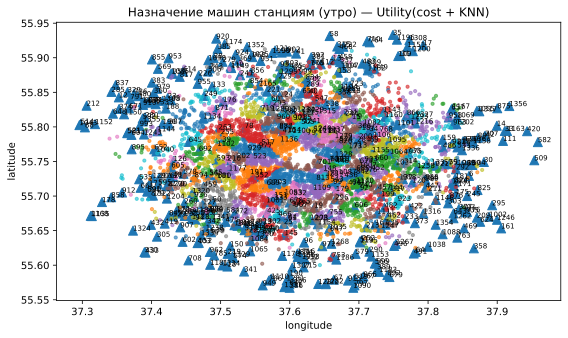

In [26]:

# === СЛОЖНЫЙ вариант назначения машин станциям: учитываем и Cost_{s j}, и score^{KNN}_{s j} ===
#
# Идея:
#   1) Как и раньше, считаем KNN‑скоры:
#        score^{KNN}_{s j} = (D_j / P_s) * f_dist(d_{s j})
#      (они уже лежат в scores_morning / scores_evening).
#   2) Считаем "физическую" стоимость обслуживания пары (станция s, машина j):
#        Cost_{s j} = P_s * D_j + c_dist_per_km * d_{s j}
#      (рубли за топливо + рубли за пробег).
#   3) Для КАЖДОЙ машины j нормируем и cost, и score^{KNN} по всем станциям s
#      и строим итоговую полезность:
#        cost_norm_{s j}   in [0, 1], меньше — лучше,
#        score_norm_{s j}  in [0, 1], больше — лучше,
#        Utility_{s j} = w_score * score_norm_{s j}
#                      + w_cost  * (1 - cost_norm_{s j}).
#      Здесь w_score, w_cost >= 0 и w_score + w_cost = 1.
#
#   4) Машина j выбирает станцию s с МАКСИМАЛЬНОЙ Utility_{s j}.
#
# Таким образом:
#   • D_j влияет дважды: в стоимости топлива P_s * D_j и в KNN‑скоре;
#   • P_s и d_{s j} тоже участвуют и в cost, и в score^{KNN};
#   • весами w_score и w_cost можно настраивать баланс "минимизировать рубли"
#     vs "сильно учитывать KNN‑ранжирование".
#
# В ДАННОЙ ячейке:
#   - мы определяем функции compute_station_car_costs и assign_cars_to_stations_complex,
#   - выполняем назначение для утреннего и вечернего парка,
#   - строим статическую карту для быстрой проверки.
#
# Примечание: latlon_distance_km уже определена выше (в ячейке со score^{KNN}).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def compute_station_car_costs(
    df_cars: pd.DataFrame,
    df_stations: pd.DataFrame,
    price_col: str,
    car_need_col: str = "needed_liters",
    car_id_col: str = "car_id",
    station_id_col: str = None,
    c_dist_per_km: float = 10.0,
) -> pd.DataFrame:
    """Строит матрицу Cost_{s j} = P_s * D_j + c_dist_per_km * d_{s j}.

    df_cars:
        lat, lon, needed_liters, car_id.
    df_stations:
        lat, lon, price_col (руб/л), опционально station_id.

    Возвращает:
        costs_df: DataFrame формы (S, N), index = station_id, columns = car_id.
    """
    cars = df_cars.copy()
    if car_need_col not in cars.columns:
        raise ValueError(f"В df_cars нет столбца '{car_need_col}' с потребностью в литрах.")

    # Идентификаторы станций
    if station_id_col is not None and station_id_col in df_stations.columns:
        station_ids = df_stations[station_id_col].tolist()
    else:
        station_ids = df_stations.index.to_list()

    car_ids = cars[car_id_col].tolist()

    # Координаты
    car_lat = cars["lat"].to_numpy()[None, :]         # (1, N)
    car_lon = cars["lon"].to_numpy()[None, :]         # (1, N)
    st_lat  = df_stations["lat"].to_numpy()[:, None]  # (S, 1)
    st_lon  = df_stations["lon"].to_numpy()[:, None]  # (S, 1)

    # Матрица расстояний d_{s j} (S, N)
    dist_km = latlon_distance_km(st_lat, st_lon, car_lat, car_lon)

    # Матрицы P_s и D_j
    P = df_stations[price_col].to_numpy()[:, None]           # (S, 1)
    D = cars[car_need_col].to_numpy()[None, :]               # (1, N)

    fuel_cost = P * D                                        # руб за топливо
    dist_cost = c_dist_per_km * dist_km                      # руб за пробег
    total_cost = fuel_cost + dist_cost

    costs_df = pd.DataFrame(total_cost, index=station_ids, columns=car_ids)
    return costs_df


def assign_cars_to_stations_complex(
    df_cars: pd.DataFrame,
    df_stations: pd.DataFrame,
    scores_df: pd.DataFrame,
    price_col: str,
    c_dist_per_km: float = 10.0,
    w_score: float = 0.6,
    w_cost: float = 0.4,
    car_need_col: str = "needed_liters",
    car_id_col: str = "car_id",
    station_id_col: str = None,
    assigned_station_col: str = "assigned_station_id",
    assigned_cost_col: str = "assigned_cost",
    assigned_score_col: str = "assigned_score",
    assigned_utility_col: str = "assigned_utility",
) -> tuple[pd.DataFrame, str]:
    """Назначает каждой машине станцию, максимизируя комбинированную Utility_{s j}.

    Utility_{s j} = w_score * score_norm_{s j} + w_cost * (1 - cost_norm_{s j}),
    где нормализация идёт по станциям для КАЖДОЙ машины j (по столбцам).

    Возвращает:
        cars_assigned, station_id_col_used
    """
    # Нормируем веса
    total_w = w_score + w_cost
    if total_w <= 0:
        raise ValueError("Сумма w_score + w_cost должна быть > 0.")
    w_score_norm = w_score / total_w
    w_cost_norm = w_cost / total_w

    cars = df_cars.copy()

    # Матрица стоимостей
    costs_df = compute_station_car_costs(
        df_cars=cars,
        df_stations=df_stations,
        price_col=price_col,
        car_need_col=car_need_col,
        car_id_col=car_id_col,
        station_id_col=station_id_col,
        c_dist_per_km=c_dist_per_km,
    )

    # Приводим scores_df к тем же индексам/колонкам на всякий случай
    scores_aligned = scores_df.loc[costs_df.index, costs_df.columns]

    # --- Нормализация по КАЖДОЙ машине (столбцу) ---
    eps = 1e-9

    # Cost: 0 = лучший (дешевле), 1 = худший (дороже)
    cost_min = costs_df.min(axis=0)
    cost_max = costs_df.max(axis=0)
    cost_range = (cost_max - cost_min).replace(0, eps)
    cost_norm = (costs_df - cost_min) / cost_range

    # Score: 0 = худший, 1 = лучший
    score_min = scores_aligned.min(axis=0)
    score_max = scores_aligned.max(axis=0)
    score_range = (score_max - score_min).replace(0, eps)
    score_norm = (scores_aligned - score_min) / score_range

    # Итоговая полезность
    utility = (
        w_score_norm * score_norm +
        w_cost_norm  * (1.0 - cost_norm)
    )

    # Для каждой машины j выбираем станцию с максимальной Utility_{s j}
    best_station_by_car = utility.idxmax(axis=0)   # car_id -> station_id

    # Создаём датафрейм машин и прикрепляем станцию
    cars = cars.merge(
        best_station_by_car.rename(assigned_station_col),
        left_on=car_id_col,
        right_index=True,
        how="left",
    )

    # Если нет явного столбца station_id, используем индекс
    if station_id_col is not None and station_id_col in df_stations.columns:
        station_id_series = df_stations[station_id_col]
    else:
        station_id_series = df_stations.index.to_series()
        station_id_col = "station_id_from_index"
        df_stations = df_stations.copy()
        df_stations[station_id_col] = station_id_series

    # Заполняем cost, score и utility выбранной пары (станция, машина)
    def lookup_values(row):
        s = row[assigned_station_col]
        j = row[car_id_col]
        try:
            c = costs_df.loc[s, j]
            sc = scores_aligned.loc[s, j]
            u = utility.loc[s, j]
        except KeyError:
            c = np.nan
            sc = np.nan
            u = np.nan
        return c, sc, u

    results = [lookup_values(row) for _, row in cars.iterrows()]
    cars[assigned_cost_col]    = [r[0] for r in results]
    cars[assigned_score_col]   = [r[1] for r in results]
    cars[assigned_utility_col] = [r[2] for r in results]

    return cars, station_id_col


# --- Применяем к утреннему и вечернему парку ---

# Коэффициент стоимости пробега (руб/км) и веса для cost/score
C_DIST_PER_KM = 10.0
W_SCORE = 0.6   # вес KNN‑скора
W_COST  = 0.4   # вес (инверсии) стоимости

cars_morning_assigned, station_id_col_used = assign_cars_to_stations_complex(
    df_morning,
    df_stations,
    scores_morning,
    price_col=PRICE_COL,
    c_dist_per_km=C_DIST_PER_KM,
    w_score=W_SCORE,
    w_cost=W_COST,
    car_need_col="needed_liters",
    car_id_col="car_id",
)

cars_evening_assigned, _ = assign_cars_to_stations_complex(
    df_evening,
    df_stations,
    scores_evening,
    price_col=PRICE_COL,
    c_dist_per_km=C_DIST_PER_KM,
    w_score=W_SCORE,
    w_cost=W_COST,
    car_need_col="needed_liters",
    car_id_col="car_id",
)

print("Пример назначенных машин (утро):")
print(
    cars_morning_assigned[
        ["car_id", "lat", "lon", "needed_liters",
         "assigned_station_id", "assigned_cost", "assigned_score", "assigned_utility"]
    ].head(10)
)

# Краткая сводка по станциям (сколько машин назначено)
print("\nСводка по станциям (утро):")
summary_morning = (
    cars_morning_assigned
    .groupby("assigned_station_id")["car_id"]
    .count()
    .rename("num_cars")
    .reset_index()
    .sort_values("num_cars", ascending=False)
)
print(summary_morning.head(10))


# --- Статическая карта для визуальной проверки ---

fig, ax = plt.subplots(figsize=(8, 8))

# Станции
ax.scatter(
    df_stations["lon"],
    df_stations["lat"],
    s=80,
    marker="^",
    label="Stations",
)

# Машины по станциям
for st_id, group in cars_morning_assigned.groupby("assigned_station_id"):
    ax.scatter(
        group["lon"],
        group["lat"],
        s=10,
        alpha=0.6,
    )

for _, row in df_stations.iterrows():
    ax.text(row["lon"], row["lat"], str(row.name), fontsize=7)

ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_title("Назначение машин станциям (утро) — Utility(cost + KNN)")
ax.set_aspect("equal", "box")

plt.tight_layout()
plt.show()


In [27]:

# === Интерактивная карта + подробный вывод по нескольким станциям ===
#
# Требуется, чтобы уже были:
#   df_stations, cars_morning_assigned, scores_morning, latlon_distance_km.

import pandas as pd
import plotly.express as px

# --- 1. Интерактивная карта (утренний парк) ---

cars_for_plot = cars_morning_assigned.copy()

cars_for_plot = cars_for_plot[
    ["car_id", "lat", "lon", "needed_liters",
     "assigned_station_id", "assigned_cost", "assigned_score", "assigned_utility"]
]

st_for_plot = df_stations.copy()
if "station_id" not in st_for_plot.columns:
    st_for_plot = st_for_plot.reset_index().rename(columns={"index": "station_id"})

fig = px.scatter(
    cars_for_plot,
    x="lon",
    y="lat",
    color="assigned_station_id",
    hover_data=["car_id", "needed_liters", "assigned_cost", "assigned_score", "assigned_utility"],
    title="Назначение машин станциям (утро) — интерактивная карта (Utility)",
)

fig.add_scatter(
    x=st_for_plot["lon"],
    y=st_for_plot["lat"],
    mode="markers+text",
    text=st_for_plot["station_id"],
    textposition="top center",
    marker=dict(size=10, symbol="triangle-up"),
    showlegend=False,
    hoverinfo="text",
)

fig.update_layout(
    xaxis_title="longitude",
    yaxis_title="latitude",
    yaxis_scaleanchor="x",
)
fig.show()

# --- 2. Подробный вывод по нескольким станциям ---

def describe_top_cars_for_station(
    station_id,
    cars_assigned: pd.DataFrame,
    df_stations: pd.DataFrame,
    top_n: int = 10,
):
    """Выводит табличку топ-N машин для выбранной станции
       среди УЖЕ назначенных ей машин:
       car_id, distance_km, needed_liters, assigned_cost, assigned_score, assigned_utility.
    """
    st = df_stations.loc[station_id]
    st_lat, st_lon = st["lat"], st["lon"]

    subset = cars_assigned[cars_assigned["assigned_station_id"] == station_id].copy()
    if subset.empty:
        print(f"Станция {station_id}: нет назначенных машин")
        return

    subset["distance_km"] = latlon_distance_km(
        st_lat,
        st_lon,
        subset["lat"].to_numpy(),
        subset["lon"].to_numpy(),
    )

    subset = subset.sort_values("assigned_utility", ascending=False)

    cols = ["car_id", "distance_km", "needed_liters",
            "assigned_cost", "assigned_score", "assigned_utility"]
    print(f"\nСтанция {station_id}: топ-{min(top_n, len(subset))} машин по Utility")
    display(subset[cols].head(top_n))


top_stations = (
    cars_morning_assigned
    .groupby("assigned_station_id")["car_id"]
    .count()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

print("Проверяем станции:", top_stations)

for st_id in top_stations:
    describe_top_cars_for_station(st_id, cars_morning_assigned, df_stations, top_n=10)


Проверяем станции: [191, 1136, 1203, 523, 813]

Станция 191: топ-10 машин по Utility


,car_id,distance_km,needed_liters,assigned_cost,assigned_score,assigned_utility
31,31,0.579823,16.164769,915.874744,0.196962,1.0
38,38,1.428383,3.907124,234.254896,0.027424,1.0
46,46,0.673947,17.106067,969.811050,0.196062,1.0
345,345,0.774732,9.757408,557.089383,0.104743,1.0
286,286,0.857579,2.013272,121.923021,0.020479,1.0
272,272,0.487472,25.958865,1466.358841,0.335868,1.0
266,266,0.653148,7.809978,446.233233,0.090733,1.0
359,359,1.369532,24.290237,1381.235664,0.177140,1.0
930,930,1.448804,15.337207,877.972799,0.106231,1.0
707,707,1.098747,17.437435,992.715040,0.151638,1.0



Станция 1136: топ-10 машин по Utility


,car_id,distance_km,needed_liters,assigned_cost,assigned_score,assigned_utility
49,49,0.163209,6.280022,378.559037,0.094101,1.0
227,227,0.439286,2.180656,135.275824,0.027308,1.0
898,898,0.896664,4.213111,261.837555,0.039191,1.0
1105,1105,2.276299,4.570089,297.059709,0.017340,1.0
795,795,0.825122,6.615247,405.298374,0.064465,1.0
722,722,0.453464,8.009130,485.242628,0.099376,1.0
1035,1035,0.436162,6.768004,410.577233,0.084926,1.0
1938,1938,1.291731,8.546133,525.856208,0.061493,1.0
2237,2237,1.139217,8.546763,524.368896,0.067907,1.0
2275,2275,0.492849,10.423058,630.520411,0.126058,1.0



Станция 1203: топ-10 машин по Utility


,car_id,distance_km,needed_liters,assigned_cost,assigned_score,assigned_utility
234,234,0.383985,5.000158,307.349426,0.064180,1.000000
780,780,0.497965,0.512219,36.071352,0.006105,1.000000
774,774,1.099843,0.447881,38.184838,0.003610,1.000000
4139,4139,0.885030,1.426626,95.446475,0.013222,1.000000
4067,4067,0.573513,6.052412,373.116518,0.068682,0.995996
2898,2898,0.900070,3.431499,217.292681,0.031493,0.994864
3388,3388,0.626963,6.408914,395.290723,0.070244,0.993740
4851,4851,1.393072,6.652556,417.740861,0.044315,0.990970
4517,4517,1.147950,5.058704,318.542834,0.039518,0.985603
3056,3056,1.234921,5.384493,339.187918,0.039751,0.984477



Станция 523: топ-10 машин по Utility


,car_id,distance_km,needed_liters,assigned_cost,assigned_score,assigned_utility
1973,1973,1.757197,0.416185,44.203627,0.002076,1.000000
2850,2850,1.630475,0.225566,30.738700,0.001221,1.000000
3472,3472,0.739422,0.184149,19.177934,0.001780,1.000000
4926,4926,0.508864,2.147568,142.511520,0.024109,0.998548
5,5,0.845492,2.099212,142.783467,0.018935,0.996869
1574,1574,1.904069,2.337902,168.643021,0.010598,0.991254
3762,3762,1.782642,1.179020,93.271928,0.005783,0.990314
631,631,1.557575,2.381625,167.975954,0.013523,0.985855
3268,3268,0.835886,4.276132,281.988568,0.038813,0.982509
4314,4314,0.645451,5.746383,374.165536,0.059031,0.974849



Станция 813: топ-10 машин по Utility


,car_id,distance_km,needed_liters,assigned_cost,assigned_score,assigned_utility
203,203,2.731850,0.210996,40.271543,0.000582,1.000000
1539,1539,0.244037,0.260792,18.450401,0.003625,1.000000
1444,1444,0.368032,3.156348,197.448492,0.040476,1.000000
2335,2335,0.497774,0.163193,14.996160,0.001923,1.000000
2173,2173,1.985073,3.406179,228.956044,0.015269,1.000000
2290,2290,0.614996,2.389036,152.812867,0.026093,0.999688
14,14,1.837229,3.399783,227.084962,0.016777,0.999112
4168,4168,1.402822,3.411041,223.432048,0.022325,0.999107
75,75,1.152743,1.470490,101.800784,0.011323,0.998712
4048,4048,1.444478,4.366195,282.485473,0.027813,0.995517


## Дополнительные функции и подсчет метрик

In [28]:
import math
import statistics

In [29]:
from math import sqrt
from typing import List

class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Car():
    def __init__(self, point, fuel_need):
        self.point = point
        self.fuel_need = fuel_need

class Tanker():
    def __init__(self, max_fuel_cap):
        self.max_fuel_cap = max_fuel_cap

# Константы для оценки стоимости
TANKER_CONSUMPTION_L_PER_100KM = 35.0   # средний расход бензовоза, л/100 км
AVERAGE_FUEL_PRICE_RUB_PER_L  = 65.0    # средняя цена бензина, ₽/л

def get_distance_cost(point1, point2):
    """
    Возвращает денежную стоимость проезда бензовоза от point1 до point2.

    - расстояние считаем по метрике Манхэттена (|dx| + |dy|), в КИЛОМЕТРАХ;
    - далее переводим км -> литры по фиксированному расходу;
    - литры -> рубли по средней цене бензина.
    """
    # Манхэттен-расстояние в км (предполагаем, что point.x/point.y уже в км)
    dx = abs(point1.x - point2.x)
    dy = abs(point1.y - point2.y)
    distance_km = dx + dy

    # Сколько литров сожрёт бензовоз на этом участке
    liters_used = distance_km * (TANKER_CONSUMPTION_L_PER_100KM / 100.0)

    # Денежная стоимость
    money_cost_rub = liters_used * AVERAGE_FUEL_PRICE_RUB_PER_L
    return money_cost_rub

In [30]:
def add_xy_km(df, center_lat=CONFIG["city_center"]["lat"], center_lon=CONFIG["city_center"]["lon"]):
    """
    Добавляем приближённые декартовы координаты (x_km, y_km) в километрах
    относительно центра города.
    """
    df = df.copy()
    df["x_km"] = (df["lon"] - center_lon) * 111.0 * np.cos(np.radians(center_lat))
    df["y_km"] = (df["lat"] - center_lat) * 111.0
    return df

In [31]:
def get_tour_cost_greedy(
    fuel_station: Point,
    cars: List[Car],
    tanker: Tanker = Tanker(300.0),
) -> tuple[float, List[List[int]]]:
    """
    Эвристический маршрут бензовоза для ОДНОЙ АЗС.

    Алгоритм:
      - пока есть незаправленные машины:
          - выбираем "seed" — машину с максимальным fuel_need;
          - едем от АЗС к seed;
          - в пределах локального радиуса вокруг seed добираем ближайшие машины,
            пока хватает топлива в бензовозе;
          - если в зоне никого не нашлось и в рейсе только seed, один раз
            пытаемся взять ближайшую машину вообще, чтобы меньше одиночных рэйсов;
          - возвращаемся на АЗС.

    Возвращает:
        total_cost: float — суммарная стоимость проезда (через get_distance_cost)
        routes: List[List[int]] — список рейсов; индексы машин в исходном списке `cars`
    """
    n = len(cars)
    if n == 0:
        return 0.0, []

    cap = float(tanker.max_fuel_cap)
    demands = [float(c.fuel_need) for c in cars]

    # Проверка вместимости
    for i, d in enumerate(demands):
        if d > cap:
            raise ValueError(
                f"Машина #{i} требует {d:.1f} л, что больше вместимости бензовоза {cap:.1f} л"
            )

    # Геометрические расстояния (в км) — манхэттен по x,y (x,y считаем км)
    dist_km = [[0.0] * n for _ in range(n)]
    for i in range(n):
        pi = cars[i].point
        for j in range(n):
            if i == j:
                dist_km[i][j] = 0.0
            else:
                pj = cars[j].point
                dist_km[i][j] = abs(pi.x - pj.x) + abs(pi.y - pj.y)

    # Оценим "типичный" радиус локального кластера — медиана расстояний до ближайшего соседа
    nn_distances = []
    for i in range(n):
        best = math.inf
        for j in range(n):
            if i == j:
                continue
            d = dist_km[i][j]
            if d < best:
                best = d
        if best < math.inf:
            nn_distances.append(best)

    if nn_distances:
        typical_nn = statistics.median(nn_distances)
        local_radius = 1.5 * typical_nn
    else:
        local_radius = 0.0

    # Стоимости проезда (рубли и т.п.) через get_distance_cost
    travel_cost = [[0.0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i == j:
                travel_cost[i][j] = 0.0
            else:
                travel_cost[i][j] = get_distance_cost(cars[i].point, cars[j].point)

    # Стоимость от АЗС до машины и обратно
    station_cost = [get_distance_cost(fuel_station, c.point) for c in cars]

    remaining = set(range(n))
    routes: List[List[int]] = []
    total_cost = 0.0

    while remaining:
        # 1) Выбираем seed — самую "пустую" машину
        seed = max(remaining, key=lambda idx: demands[idx])
        route = [seed]
        remaining.remove(seed)

        fuel_left = cap - demands[seed]
        current = seed

        # Стоимость рейса: АЗС -> seed
        route_cost = station_cost[seed]

        # 2) Собираем локальный кластер вокруг seed
        while True:
            best_j = None
            best_metric = None

            for j in remaining:
                need_j = demands[j]
                if need_j > fuel_left:
                    continue

                # j должна лежать в "зоне влияния" seed
                if dist_km[seed][j] > local_radius:
                    continue

                # выбираем ближайшую к текущей машине
                d = dist_km[current][j]
                if best_metric is None or d < best_metric or (
                    d == best_metric and demands[j] > demands[best_j]
                ):
                    best_metric = d
                    best_j = j

            if best_j is None:
                break  # в зоне больше никого не набирается

            # Едем к best_j
            route_cost += travel_cost[current][best_j]
            fuel_left -= demands[best_j]
            route.append(best_j)
            remaining.remove(best_j)
            current = best_j

        # 3) Если вокруг seed никого не оказалось (или радиус очень маленький),
        #    а топлива ещё много — попробуем подхватить самую близкую машину вообще,
        #    чтобы меньше одиночных рейсов.
        if len(route) == 1 and remaining:
            best_j = None
            best_metric = None
            for j in remaining:
                if demands[j] > fuel_left:
                    continue
                d = dist_km[current][j]
                if best_metric is None or d < best_metric or (
                    d == best_metric and demands[j] > demands[best_j]
                ):
                    best_metric = d
                    best_j = j

            if best_j is not None:
                route_cost += travel_cost[current][best_j]
                fuel_left -= demands[best_j]
                route.append(best_j)
                remaining.remove(best_j)
                current = best_j

        # 4) Возвращаемся на АЗС
        route_cost += station_cost[current]
        total_cost += route_cost
        routes.append(route)

    return total_cost, routes

In [32]:
def get_tour_cost_carp(fuel_station: Point,
                  cars: List[Car],
                  tanker: Tanker = Tanker(300.0)) -> tuple[float, List[List[int]]]:
    """
    Возвращает:
        total_cost: float  — минимальная стоимость объезда всех машин от одной АЗС
        routes: List[List[int]] — список рейсов; каждый рейс — список индексов машин в `cars`
    """
    n = len(cars)
    if n == 0:
        return 0.0, []

    cap = tanker.max_fuel_cap
    demands = [car.fuel_need for car in cars]

    # Проверка на валидность
    if any(d > cap for d in demands):
        raise ValueError("Есть машина, которой нужно топлива больше, чем вмещает бензовоз")

    # 0 — заправка, 1..n — машины
    points = [fuel_station] + [car.point for car in cars]
    cost = [[0.0] * (n + 1) for _ in range(n + 1)]
    for i in range(n + 1):
        for j in range(n + 1):
            if i == j:
                cost[i][j] = 0.0
            else:
                cost[i][j] = get_distance_cost(points[i], points[j])

    ALL_MASK = 1 << n

    # Суммарный запрос топлива для каждого подмножества машин
    subset_demand = [0.0] * ALL_MASK
    for mask in range(1, ALL_MASK):
        lsb = mask & -mask
        idx = lsb.bit_length() - 1
        subset_demand[mask] = subset_demand[mask ^ lsb] + demands[idx]

    INF = float("inf")

    # Held–Karp: dp[mask][j] — минимум depot -> ... -> j, посетив mask
    dp = [[INF] * n for _ in range(ALL_MASK)]
    parent = [[-1] * n for _ in range(ALL_MASK)]

    # База: depot -> j
    for j in range(n):
        mask = 1 << j
        dp[mask][j] = cost[0][j + 1]
        parent[mask][j] = -1

    # Переходы
    for mask in range(1, ALL_MASK):
        # один бит — база
        if mask & (mask - 1) == 0:
            continue

        for j in range(n):
            if not (mask & (1 << j)):
                continue

            prev_mask = mask ^ (1 << j)
            if prev_mask == 0:
                continue

            best_cost = INF
            best_prev = -1
            sub = prev_mask
            while sub:
                lsb = sub & -sub
                i = lsb.bit_length() - 1
                cand = dp[prev_mask][i] + cost[i + 1][j + 1]
                if cand < best_cost:
                    best_cost = cand
                    best_prev = i
                sub ^= lsb

            dp[mask][j] = best_cost
            parent[mask][j] = best_prev

    # Стоимость оптимального цикла для каждого подмножества (если укладывается в cap)
    tsp_cost = [INF] * ALL_MASK
    tsp_end = [-1] * ALL_MASK

    for mask in range(1, ALL_MASK):
        if subset_demand[mask] > cap:
            continue

        best = INF
        best_end = -1
        sub = mask
        while sub:
            lsb = sub & -sub
            j = lsb.bit_length() - 1
            cand = dp[mask][j] + cost[j + 1][0]
            if cand < best:
                best = cand
                best_end = j
            sub ^= lsb

        tsp_cost[mask] = best
        tsp_end[mask] = best_end

    # DP по подмножествам: разбиваем на рейсы
    F = [INF] * ALL_MASK
    choice = [0] * ALL_MASK
    F[0] = 0.0

    for mask in range(1, ALL_MASK):
        sub = mask
        while sub:
            if tsp_cost[sub] < INF:
                rem = mask ^ sub
                cand = tsp_cost[sub] + F[rem]
                if cand < F[mask]:
                    F[mask] = cand
                    choice[mask] = sub
            sub = (sub - 1) & mask

    total_cost = F[ALL_MASK - 1]

    # Восстановление маршрутов
    def reconstruct_route(mask: int) -> List[int]:
        end = tsp_end[mask]
        if end == -1:
            return []
        order: List[int] = []
        cur = end
        cur_mask = mask
        while True:
            order.append(cur)
            prev = parent[cur_mask][cur]
            if prev == -1:
                break
            cur_mask ^= (1 << cur)
            cur = prev
        order.reverse()
        return order

    routes: List[List[int]] = []
    mask = ALL_MASK - 1
    while mask:
        sub = choice[mask]
        route = reconstruct_route(sub)
        routes.append(route)
        mask ^= sub

    routes.reverse()
    return total_cost, routes

In [33]:
def get_tour_cost(fuel_station: Point,
                  cars: List[Car],
                  tanker: Tanker = Tanker(300.0)) -> tuple[float, List[List[int]]]:
    if (len(cars) < 12):
        return get_tour_cost_carp(fuel_station, cars, tanker)
    else:
        return get_tour_cost_greedy(fuel_station, cars, tanker)

In [34]:
# Средняя скорость бензовоза по городу, км/ч
AVERAGE_TANKER_SPEED_KMPH = 30.0

# Стоимость простоя, руб/мин (можно менять)
WAIT_COST_RUB_PER_MIN = 9.0

def compute_metrics_from_table(
    df_assign,
    df_stations,
    tanker_capacity_liters: float = 300.0,
    downtime_cost_rub_per_min: float = WAIT_COST_RUB_PER_MIN,
    only_need_refuel: bool = True,
):
    """
    Версия compute_metrics, которая принимает одну таблицу с машинами и их назначенными АЗС.

    Ожидается, что df_assign имеет колонки:
      - car_id
      - lat, lon
      - needed_liters
      - need_refuel (bool)
      - assigned_station_id

    df_stations:
      - lat, lon
      - price  (цена топлива за литр)
      - опционально: station_id (если assigned_station_id ссылается на неё)

    Делает то же самое, что и compute_metrics:
      - считает стоимость пробега бензовозов (total_travel_cost) через get_tour_cost / get_distance_cost;
      - считает стоимость простоя машин (total_wait_cost) из времени ожидания и ставки downtime_cost_rub_per_min;
      - считает стоимость закупки топлива на АЗС (total_fuel_purchase_cost);
      - возвращает dict метрик.
    """

    # --- Подготовка машин ---
    cars = df_assign.copy()

    if only_need_refuel and "need_refuel" in cars.columns:
        cars = cars[cars["need_refuel"]].copy()

    required_cols = {"car_id", "lat", "lon", "needed_liters", "assigned_station_id"}
    missing = required_cols - set(cars.columns)
    if missing:
        raise ValueError(f"В df_assign не хватает колонок: {missing}")

    cars_xy = add_xy_km(cars)  # добавит x_km, y_km

    # --- Подготовка АЗС ---
    stations_xy = add_xy_km(df_stations).copy()

    if "price" not in stations_xy.columns:
        raise ValueError("В df_stations нет колонки 'price' с ценой топлива.")

    # Маппинг assigned_station_id -> строка АЗС
    use_station_id_col = "station_id" in stations_xy.columns
    if use_station_id_col:
        # station_id -> индекс строки
        station_id_to_idx = {
            stations_xy.iloc[i]["station_id"]: i for i in range(len(stations_xy))
        }

    def get_station_row(assigned_id):
        if use_station_id_col:
            idx = station_id_to_idx.get(assigned_id)
            if idx is None:
                return None
            return stations_xy.iloc[idx]
        else:
            # считаем, что assigned_id == index в df_stations
            try:
                return stations_xy.loc[assigned_id]
            except KeyError:
                try:
                    return stations_xy.iloc[int(assigned_id)]
                except Exception:
                    return None

    # --- Группируем машины по АЗС ---
    from collections import defaultdict

    station_to_row_indices = defaultdict(list)
    for idx, row in cars_xy.iterrows():
        sid = row["assigned_station_id"]
        station_to_row_indices[sid].append(idx)

    total_travel_cost = 0.0
    total_fuel_purchase_cost = 0.0
    per_car_wait_time_hours = {}

    tanker = Tanker(tanker_capacity_liters)

    # --- Обрабатываем каждую станцию: строим маршрут, считаем пробег, ожидания, закупку топлива ---
    for assigned_id, car_idx_list in station_to_row_indices.items():
        st_row = get_station_row(assigned_id)
        if st_row is None:
            continue  # не нашли такую станцию в df_stations

        station_point = Point(st_row["x_km"], st_row["y_km"])
        station_price = float(st_row["price"])

        # Формируем список машин для get_tour_cost
        cars_for_tour: list[Car] = []
        idx_list: list[int] = []
        station_liters = 0.0

        for idx in car_idx_list:
            r = cars_xy.loc[idx]
            fuel_need = float(r["needed_liters"])
            if fuel_need <= 0:
                continue
            car_point = Point(r["x_km"], r["y_km"])
            cars_for_tour.append(Car(car_point, fuel_need))
            idx_list.append(idx)
            station_liters += fuel_need

        if not cars_for_tour:
            continue

        # 1) Строим маршрут для этой АЗС (получаем порядок машин)
        station_travel_cost, routes_local = get_tour_cost(station_point, cars_for_tour, tanker)
        total_travel_cost += station_travel_cost

        # 2) Считаем время ожидания машин (в часах) по построенным маршрутам
        current_time_h = 0.0  # локальное время для этой АЗС

        for trip in routes_local:
            if not trip:
                continue

            prev_x = station_point.x
            prev_y = station_point.y

            for local_i in trip:
                global_idx = idx_list[local_i]
                row_car = cars_xy.loc[global_idx]
                car_id = int(row_car["car_id"])
                cx = row_car["x_km"]
                cy = row_car["y_km"]

                # расстояние в км (Манхэттен)
                dx = abs(prev_x - cx)
                dy = abs(prev_y - cy)
                segment_distance_km = dx + dy

                # время участка
                segment_time_h = segment_distance_km / AVERAGE_TANKER_SPEED_KMPH
                current_time_h += segment_time_h

                # обновляем время ожидания машины
                prev_wait = per_car_wait_time_hours.get(car_id)
                if prev_wait is None or current_time_h < prev_wait:
                    per_car_wait_time_hours[car_id] = current_time_h

                prev_x, prev_y = cx, cy

            # возврат на АЗС (для времени, но без ожиданий машин)
            dx_back = abs(prev_x - station_point.x)
            dy_back = abs(prev_y - station_point.y)
            back_distance_km = dx_back + dy_back
            back_time_h = back_distance_km / AVERAGE_TANKER_SPEED_KMPH
            current_time_h += back_time_h

        # 3) Стоимость закупки топлива для этой АЗС
        total_fuel_purchase_cost += station_liters * station_price

    # --- Переводим времена ожидания в деньги ---
    per_car_wait_cost = {}
    for car_id, wait_hours in per_car_wait_time_hours.items():
        wait_minutes = wait_hours * 60.0
        per_car_wait_cost[car_id] = wait_minutes * downtime_cost_rub_per_min

    total_wait_cost = sum(per_car_wait_cost.values())
    num_cars_served = len(per_car_wait_cost)
    avg_wait_cost_per_car = total_wait_cost / num_cars_served if num_cars_served > 0 else 0.0

    total_cost = total_travel_cost + total_wait_cost + total_fuel_purchase_cost

    metrics = {
        "total_travel_cost": total_travel_cost,
        "total_wait_cost": total_wait_cost,
        "total_fuel_purchase_cost": total_fuel_purchase_cost,
        "total_cost": total_cost,
        "per_car_wait_cost": per_car_wait_cost,
        "avg_wait_cost_per_car": avg_wait_cost_per_car,
    }

    print(
        f"Стоимость проезда: {total_travel_cost:.2f} руб, "
        f"стоимость простоя: {total_wait_cost:.2f} руб, "
        f"закупка топлива: {total_fuel_purchase_cost:.2f} руб, "
        f"итоговая стоимость: {total_cost:.2f} руб, "
        f"средний простой на машину: {avg_wait_cost_per_car:.2f} руб"
    )

    return metrics


## Подсчет метрики

In [35]:
metrics = compute_metrics_from_table(
    df_assign=cars_morning_assigned,  # та самая таблица с assigned_station_id
    df_stations=df_stations,
    tanker_capacity_liters=300.0,
    downtime_cost_rub_per_min=9.0,
)

print(metrics["total_cost"])

Стоимость проезда: 33507.09 руб, стоимость простоя: 136832.09 руб, закупка топлива: 2545462.06 руб, итоговая стоимость: 2715801.24 руб, средний простой на машину: 111.43 руб
2715801.2445999165


# Пробуем бить машины по группам

In [36]:
# ============================================
# KNN-кластеризация машин с ограничением по объёму (≤ 300 л)
# и назначение КЛАСТЕРОВ на АЗС по старой метрике score_{s j}
# ============================================

from typing import Dict

def build_capacity_knn_clusters(
    df_cars_need: pd.DataFrame,
    max_cluster_capacity: float = 300.0,
    car_need_col: str = "needed_liters",
    k_neighbors: int = 50,
    max_radius_factor: float = 2.5,
) -> pd.DataFrame:
    """
    Разбивает машины на кластеры так, чтобы:
      - сумма `car_need_col` в кластере ≤ max_cluster_capacity;
      - машины в кластере географически близки (по x_km, y_km);
      - кластер строится по принципу KNN (берём ближайших к центроиду кластера).

    Вход:
        df_cars_need — таблица машин, которым НУЖНА заправка
                       (обычно df[df['need_refuel']]).

    Выход: копия df_cars_need с добавленными колонками:
        - x_km, y_km          — декартовы координаты в км (от центра города);
        - cluster_id          — целочисленный id кластера;
        - cluster_total_need  — суммарная потребность кластера (литры).
    """

    if df_cars_need.empty:
        return df_cars_need.assign(
            x_km=pd.Series(dtype=float),
            y_km=pd.Series(dtype=float),
            cluster_id=pd.Series(dtype=int),
            cluster_total_need=pd.Series(dtype=float),
        )

    # Сохраним исходный индекс, чтобы потом вернуться к нему
    cars = df_cars_need.reset_index().rename(columns={"index": "_orig_index"}).copy()

    # Координаты в км относительно центра города
    cars = add_xy_km(cars)
    coords = cars[["x_km", "y_km"]].to_numpy()
    needs = cars[car_need_col].to_numpy()
    n = len(cars)

    # --- Оценка "типичного" расстояния до ближайшего соседа ---
    # Используем манхэттен-метрику (как в get_tour_cost_greedy),
    # чтобы получить разумный радиус кластера.
    if n > 1:
        nn_dists = np.empty(n, dtype=float)
        for i in range(n):
            diff = np.abs(coords - coords[i])      # (n, 2)
            dist = diff.sum(axis=1)               # манхэттен
            dist[i] = np.inf                      # себя не считаем
            nn_dists[i] = dist.min()
        typical_nn = np.median(nn_dists[np.isfinite(nn_dists)])
        # Максимальный "географический" радиус кластера
        max_radius = max_radius_factor * typical_nn if typical_nn > 0 else np.inf
    else:
        max_radius = np.inf

    cluster_id = np.full(n, -1, dtype=int)
    current_cluster = 0
    unassigned: set[int] = set(range(n))

    while unassigned:
        # 1) Берём seed — машину с максимальной потребностью
        seed = max(unassigned, key=lambda i: needs[i])
        members = [seed]
        total_need = needs[seed]
        unassigned.remove(seed)

        # 2) Растим кластер ближайшими соседями,
        #    пока есть ёмкость и есть кто-то в окрестности.
        while len(members) < k_neighbors and unassigned:
            centroid = coords[members].mean(axis=0)
            # Индексы ещё не назначенных машин
            rest_idx = np.fromiter(unassigned, dtype=int)
            diff = np.abs(coords[rest_idx] - centroid)
            dists = diff.sum(axis=1)              # манхэттен
            order = np.argsort(dists)            # ближайшие вперёд

            added = False
            for pos in order:
                i = rest_idx[pos]
                # Если уже далеко от центроида — дальше только хуже
                if dists[pos] > max_radius:
                    break
                # Проверяем ограничение по суммарной потребности
                if total_need + needs[i] > max_cluster_capacity:
                    continue
                # Добавляем машину в кластер
                members.append(i)
                total_need += needs[i]
                unassigned.remove(i)
                added = True
                if len(members) >= k_neighbors:
                    break

            # Не удалось никого добавить — заканчиваем рост кластера
            if not added:
                break

        # Фиксируем id кластера для всех его машин
        for i in members:
            cluster_id[i] = current_cluster
        current_cluster += 1

    cars["cluster_id"] = cluster_id
    cars["cluster_total_need"] = cars.groupby("cluster_id")[car_need_col].transform("sum")

    # Возвращаемся к исходному индексу, подмешиваем новые столбцы
    cars = cars.set_index("_orig_index").sort_index()
    result = df_cars_need.copy()
    for col in ["x_km", "y_km", "cluster_id", "cluster_total_need"]:
        result[col] = cars[col]

    return result


def assign_clusters_to_best_station(
    df_cars_clustered: pd.DataFrame,
    scores_df: pd.DataFrame,
    cluster_col: str = "cluster_id",
    car_id_col: str = "car_id",
    assigned_station_col: str = "assigned_station_id",
    assigned_score_col: str = "assigned_score",
) -> pd.DataFrame:
    """
    Назначает КАЖДОМУ кластеру одну АЗС, максимизируя суммарный score по кластерам.

    Вход:
        df_cars_clustered — результат build_capacity_knn_clusters
                            (для машин, которым нужна заправка).
        scores_df         — матрица score_{s j} (index = station_id, columns = car_id),
                            как возвращает compute_station_car_scores.

    Выход:
        копия df_cars_clustered с добавленными колонками:
        - assigned_station_id  — id выбранной АЗС для кластера;
        - assigned_score       — score конкретной машины j на выбранной АЗС.
    """
    cars = df_cars_clustered.copy()
    if cluster_col not in cars.columns:
        raise ValueError(f"В df_cars_clustered нет колонки '{cluster_col}' с id кластера")

    cluster_to_station: Dict[int, int] = {}
    cluster_to_cluster_score: Dict[int, float] = {}

    # Для каждого кластера считаем суммарный score по всем станциям
    for cl_id, group in cars.groupby(cluster_col):
        car_ids = group[car_id_col].tolist()
        # На всякий случай фильтруем по наличию в матрице score
        car_ids_existing = [cid for cid in car_ids if cid in scores_df.columns]
        if not car_ids_existing:
            continue

        # Сумма score по всем машинам кластера → один вектор по станциям
        cluster_scores = scores_df[car_ids_existing].sum(axis=1)  # index = station_id
        best_station = cluster_scores.idxmax()
        cluster_to_station[cl_id] = best_station
        cluster_to_cluster_score[cl_id] = float(cluster_scores.loc[best_station])

    # Применяем выбранную станцию к каждой машине кластера
    cars[assigned_station_col] = cars[cluster_col].map(cluster_to_station)

    # Пер-ка: для совместимости оставим "индивидуальный" score
    def _per_car_score(row):
        st = row[assigned_station_col]
        cid = row[car_id_col]
        if pd.isna(st):
            return np.nan
        try:
            return float(scores_df.loc[st, cid])
        except KeyError:
            return np.nan

    cars[assigned_score_col] = cars.apply(_per_car_score, axis=1)

    return cars


# ============================================
# Пример: утренний парк с KNN-кластерами
# ============================================

# 1. Берём только машины, которым реально нужна заправка
cars_need_morning = df_morning[df_morning["need_refuel"]].copy()

# 2. Строим KNN-кластеры с ограничением по объёму бензовоза (300 л)
cars_need_morning_clustered = build_capacity_knn_clusters(
    cars_need_morning,
    max_cluster_capacity=300.0,      # вместимость бензовоза
    car_need_col="needed_liters",
    k_neighbors=50,                  # максимальный размер кластера (можно подбирать)
    max_radius_factor=2.5,           # насколько "широкими" могут быть кластеры по геометрии
)

# 3. Назначаем каждому кластеру лучшую АЗС по суммарной метрике score
cars_need_morning_group_assigned = assign_clusters_to_best_station(
    cars_need_morning_clustered,
    scores_morning,                  # уже посчитанная матрица score_{s j}
    cluster_col="cluster_id",
    car_id_col="car_id",
)

# 4. Сливаем обратно с полным df_morning (чтобы сохранить формат df_assign)
cars_morning_group_assigned = df_morning.merge(
    cars_need_morning_group_assigned[
        ["car_id", "x_km", "y_km", "cluster_id",
         "cluster_total_need", "assigned_station_id", "assigned_score"]
    ],
    on="car_id",
    how="left",
)

print("Пример утренних групп:")
print(
    cars_morning_group_assigned[
        ["car_id", "cluster_id", "cluster_total_need",
         "needed_liters", "need_refuel", "assigned_station_id"]
    ]
    .head(15)
)

# 5. Считаем метрики, как и раньше, но уже с групповым назначением
metrics_morning_groups = compute_metrics_from_table(
    df_assign=cars_morning_group_assigned,
    df_stations=df_stations,
    tanker_capacity_liters=300.0,
    downtime_cost_rub_per_min=WAIT_COST_RUB_PER_MIN,
)

print("\nИтоговая стоимость (утро, кластеризация+групповое назначение):",
      metrics_morning_groups["total_cost"])

Пример утренних групп:
    car_id  cluster_id  cluster_total_need  needed_liters  need_refuel  \
0        0         NaN                 NaN      17.031871        False   
1        1         NaN                 NaN       8.885171        False   
2        2         NaN                 NaN      17.081824        False   
3        3       174.0          215.793666      38.339875         True   
4        4         NaN                 NaN       9.311319        False   
5        5         NaN                 NaN       2.099212        False   
6        6         NaN                 NaN      13.685883        False   
7        7         NaN                 NaN       9.345586        False   
8        8         NaN                 NaN       9.777540        False   
9        9         NaN                 NaN      14.622757        False   
10      10         NaN                 NaN       9.627584        False   
11      11         NaN                 NaN      18.517048        False   
12      12     

# Подбор гиперпараметров

In [ ]:
# ============================================================
# Импорт библиотек
# ============================================================
# При необходимости раскомментируйте:
# !pip install scikit-optimize

import numpy as np
import pandas as pd

from skopt import gp_minimize
from skopt.space import Real, Categorical
from skopt.utils import use_named_args


In [ ]:
# ============================================================
# Проверка наличия базовых объектов окружения
# ============================================================

required_names = ["df_stations", "df_morning", "compute_station_car_scores",
                  "assign_cars_to_stations", "compute_metrics_from_table",
                  "WAIT_COST_RUB_PER_MIN"]

missing = [name for name in required_names if name not in globals()]

if missing:
    print("⚠️ Внимание: в окружении не найдены следующие объекты/функции:")
    for name in missing:
        print(" -", name)
    print("\nНоутбук всё равно можно запускать, но соответствующие ячейки нужно адаптировать.")
else:
    print("✅ Все ожидаемые объекты найдены в окружении.")


⚠️ Внимание: в окружении не найдены следующие объекты/функции:
 - assign_cars_to_stations

Ноутбук всё равно можно запускать, но соответствующие ячейки нужно адаптировать.


In [ ]:
# ==========================================
# 1. Выбор столбца с ценой топлива (PRICE_COL)
# ==========================================

if "df_stations" not in globals():
    raise RuntimeError("df_stations не найден. Определите df_stations выше или импортируйте его.")

if "price" in df_stations.columns:
    PRICE_COL = "price"
else:
    numeric_cols = df_stations.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise ValueError(
            "Не удалось найти числовой столбец с ценой топлива в df_stations. "
            "Добавьте колонку 'price' или укажите PRICE_COL вручную."
        )
    PRICE_COL = numeric_cols[0]

print(f"Для стоимости топлива используем столбец: {PRICE_COL}")


Для стоимости топлива используем столбец: price


In [ ]:
# ==========================================
# 2. Функция: итоговая стоимость для одного DataFrame с машинами
# ==========================================

def evaluate_total_cost_for_df(
    df_cars: pd.DataFrame,
    df_stations: pd.DataFrame,
    *,
    mode: str,
    gamma: float,
    p: float,
    epsilon: float,
    tanker_capacity_liters: float = 300.0,
    downtime_cost_rub_per_min: float = None,
) -> float:
    """
    df_cars        — таблица машин (например df_morning или df_evening)
    df_stations    — таблица станций
    mode           — 'exp' или 'power' (как в compute_station_car_scores)
    gamma, p, epsilon — гиперпараметры скоринга

    Возвращает:
        metrics["total_cost"] из compute_metrics_from_table.
    """
    if downtime_cost_rub_per_min is None:
        if "WAIT_COST_RUB_PER_MIN" not in globals():
            raise RuntimeError("WAIT_COST_RUB_PER_MIN не найден. Определите константу выше.")
        downtime_cost_rub_per_min = WAIT_COST_RUB_PER_MIN

    # 1) Считаем скоринговую матрицу station–car (KNN-скор)
    scores = compute_station_car_scores(
        df_cars=df_cars,
        df_stations=df_stations,
        price_col=PRICE_COL,
        mode=mode,
        gamma=gamma,
        epsilon=epsilon,
        p=p,
        car_need_col="needed_liters",
        car_id_col="car_id",
        station_id_col=None,  # если у станций есть station_id — функция сама это учтёт
    )

    # 2) Назначаем машины станциям через твою сложную функцию UTILITY (cost + KNN)
    #    тут мы ПРЯМО используем assign_cars_to_stations_complex
    df_assigned, _ = assign_cars_to_stations_complex(
        df_cars=df_cars,
        df_stations=df_stations,
        scores_df=scores,
        price_col=PRICE_COL,
        c_dist_per_km=C_DIST_PER_KM,  # те же константы, что и в ноутбуке
        w_score=W_SCORE,
        w_cost=W_COST,
        car_need_col="needed_liters",
        car_id_col="car_id",
    )

    # 3) Считаем итоговые метрики, включая total_cost
    metrics = compute_metrics_from_table(
        df_assign=df_assigned,
        df_stations=df_stations,
        tanker_capacity_liters=tanker_capacity_liters,
        downtime_cost_rub_per_min=downtime_cost_rub_per_min,
        only_need_refuel=True,  # считаем только машины с need_refuel == True
    )

    return float(metrics["total_cost"])


In [ ]:
# ==========================================
# 3. Пространство гиперпараметров для байесовской оптимизации
# ==========================================

# Оптимизируем:
#   - режим расстояния: mode ∈ {"exp", "power"}
#   - gamma: параметр для экспоненциальной/другой формы
#   - p:     степень в 1 / (d + eps)^p для mode="power"
#   - epsilon: сглаживание в 1 / (d + eps)^p

space = [
    Categorical(["exp", "power"], name="mode"),
    Real(0.01, 2.0, name="gamma"),
    Real(0.5, 4.0, name="p"),
    Real(0.001, 0.5, name="epsilon"),
]


In [ ]:
# ==========================================
# 4. Целевая функция для gp_minimize
# ==========================================

if "df_morning" not in globals():
    raise RuntimeError("df_morning не найден. Определите df_morning выше (таблица машин на утро).")

@use_named_args(space)
def objective(mode, gamma, p, epsilon):
    """        Возвращает среднюю итоговую стоимость (total_cost) по одному или двум сценариям:
    - всегда учитываем df_morning;
    - если в окружении есть df_evening, добавляем его как второй сценарий.
    """
    costs = []

    # Утро — обязательный сценарий
    cost_morning = evaluate_total_cost_for_df(
        df_cars=df_morning,
        df_stations=df_stations,
        mode=mode,
        gamma=gamma,
        p=p,
        epsilon=epsilon,
    )
    costs.append(cost_morning)

    # Вечер — опционально, если в ноутбуке уже есть df_evening
    if "df_evening" in globals():
        cost_evening = evaluate_total_cost_for_df(
            df_cars=df_evening,
            df_stations=df_stations,
            mode=mode,
            gamma=gamma,
            p=p,
            epsilon=epsilon,
        )
        costs.append(cost_evening)

    mean_cost = float(np.mean(costs))

    print(
        f"mode={mode:>5}, gamma={gamma:.3f}, p={p:.3f}, eps={epsilon:.4f} "
        f"-> mean_total_cost={mean_cost:.2f}"
    )

    return mean_cost


In [ ]:
# ==========================================
# 5. Запуск байесовской оптимизации
# ==========================================

N_CALLS = 40          # всего оценок (можно увеличить до 60–100)
N_INITIAL_POINTS = 8  # сколько точек взять случайно до ГП

result = gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=N_CALLS,
    n_initial_points=N_INITIAL_POINTS,
    acq_func="EI",        # Expected Improvement
    noise="gaussian",     # допускаем шум в objective
    random_state=42,
)

print("\n==============================")
print("БАЙЕСОВСКАЯ ОПТИМИЗАЦИЯ ЗАВЕРШЕНА")
print("==============================\n")

print("Лучшее найденное значение целевой функции (mean_total_cost):", result.fun)
print("Лучшие гиперпараметры (raw):", result.x)

best_mode, best_gamma, best_p, best_epsilon = result.x

print("\nРазобранные лучшие гиперпараметры:")
print(f"  mode    : {best_mode}")
print(f"  gamma   : {best_gamma:.4f}")
print(f"  p       : {best_p:.4f}")
print(f"  epsilon : {best_epsilon:.4f}")


Стоимость проезда: 33591.31 руб, стоимость простоя: 128455.24 руб, закупка топлива: 2555864.15 руб, итоговая стоимость: 2717910.70 руб, средний простой на машину: 104.61 руб
Стоимость проезда: 38040.42 руб, стоимость простоя: 124597.10 руб, закупка топлива: 2532449.39 руб, итоговая стоимость: 2695086.92 руб, средний простой на машину: 104.09 руб
mode=power, gamma=0.375, p=3.229, eps=0.2988 -> mean_total_cost=2706498.81
Стоимость проезда: 35705.00 руб, стоимость простоя: 233924.11 руб, закупка топлива: 2523882.90 руб, итоговая стоимость: 2793512.02 руб, средний простой на машину: 190.49 руб
Стоимость проезда: 39589.99 руб, стоимость простоя: 147408.88 руб, закупка топлива: 2498214.85 руб, итоговая стоимость: 2685213.72 руб, средний простой на машину: 123.15 руб
mode=  exp, gamma=0.209, p=2.107, eps=0.1675 -> mean_total_cost=2739362.87
Стоимость проезда: 33519.28 руб, стоимость простоя: 130055.08 руб, закупка топлива: 2552384.10 руб, итоговая стоимость: 2715958.47 руб, средний простой на

/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.str_('power'), 2.0, 4.0, 0.001] before, using random point ['exp', 0.667314292649365, 0.6935326137751274, 0.07073596403072012]



Стоимость проезда: 33678.34 руб, стоимость простоя: 137621.37 руб, закупка топлива: 2545605.37 руб, итоговая стоимость: 2716905.07 руб, средний простой на машину: 112.07 руб
Стоимость проезда: 38427.44 руб, стоимость простоя: 130633.59 руб, закупка топлива: 2519010.72 руб, итоговая стоимость: 2688071.75 руб, средний простой на машину: 109.13 руб
mode=  exp, gamma=0.667, p=0.694, eps=0.0707 -> mean_total_cost=2702488.41
Стоимость проезда: 33626.13 руб, стоимость простоя: 127938.17 руб, закупка топлива: 2557589.66 руб, итоговая стоимость: 2719153.96 руб, средний простой на машину: 104.18 руб
Стоимость проезда: 38007.94 руб, стоимость простоя: 122177.02 руб, закупка топлива: 2534960.98 руб, итоговая стоимость: 2695145.94 руб, средний простой на машину: 102.07 руб
mode=power, gamma=2.000, p=3.966, eps=0.0010 -> mean_total_cost=2707149.95
Стоимость проезда: 33556.03 руб, стоимость простоя: 127793.06 руб, закупка топлива: 2557448.35 руб, итоговая стоимость: 2718797.44 руб, средний простой на

/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.str_('power'), 2.0, 4.0, 0.001] before, using random point ['power', 1.9251385517564439, 3.0291680746269103, 0.025912810808852497]



Стоимость проезда: 33607.40 руб, стоимость простоя: 127237.57 руб, закупка топлива: 2556609.76 руб, итоговая стоимость: 2717454.73 руб, средний простой на машину: 103.61 руб
Стоимость проезда: 38188.97 руб, стоимость простоя: 125491.81 руб, закупка топлива: 2533542.14 руб, итоговая стоимость: 2697222.91 руб, средний простой на машину: 104.84 руб
mode=power, gamma=1.925, p=3.029, eps=0.0259 -> mean_total_cost=2707338.82
Стоимость проезда: 33607.40 руб, стоимость простоя: 127237.57 руб, закупка топлива: 2556609.76 руб, итоговая стоимость: 2717454.73 руб, средний простой на машину: 103.61 руб
Стоимость проезда: 38093.72 руб, стоимость простоя: 125604.43 руб, закупка топлива: 2533692.42 руб, итоговая стоимость: 2697390.57 руб, средний простой на машину: 104.93 руб
mode=power, gamma=2.000, p=4.000, eps=0.3790 -> mean_total_cost=2707422.65


/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.str_('power'), 2.0, 4.0, 0.001] before, using random point ['power', 0.986333569977809, 3.2608052003882, 0.47076668283977313]



Стоимость проезда: 33580.32 руб, стоимость простоя: 128812.45 руб, закупка топлива: 2555506.45 руб, итоговая стоимость: 2717899.23 руб, средний простой на машину: 104.90 руб
Стоимость проезда: 38000.73 руб, стоимость простоя: 124603.21 руб, закупка топлива: 2532269.74 руб, итоговая стоимость: 2694873.68 руб, средний простой на машину: 104.10 руб
mode=power, gamma=0.986, p=3.261, eps=0.4708 -> mean_total_cost=2706386.45


/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.str_('power'), 2.0, 4.0, 0.001] before, using random point ['power', 0.32387821876785355, 0.5046108110444397, 0.4586125889369449]



Стоимость проезда: 34672.47 руб, стоимость простоя: 181879.18 руб, закупка топлива: 2535749.79 руб, итоговая стоимость: 2752301.45 руб, средний простой на машину: 148.11 руб
Стоимость проезда: 38724.36 руб, стоимость простоя: 130715.40 руб, закупка топлива: 2508801.27 руб, итоговая стоимость: 2678241.03 руб, средний простой на машину: 109.20 руб
mode=power, gamma=0.324, p=0.505, eps=0.4586 -> mean_total_cost=2715271.24


/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.str_('power'), 2.0, 4.0, 0.001] before, using random point ['power', 0.42091523762754246, 2.046151632948786, 0.09075432744420651]



Стоимость проезда: 33633.22 руб, стоимость простоя: 131915.44 руб, закупка топлива: 2554148.23 руб, итоговая стоимость: 2719696.88 руб, средний простой на машину: 107.42 руб
Стоимость проезда: 38118.39 руб, стоимость простоя: 126731.45 руб, закупка топлива: 2531422.52 руб, итоговая стоимость: 2696272.36 руб, средний простой на машину: 105.87 руб
mode=power, gamma=0.421, p=2.046, eps=0.0908 -> mean_total_cost=2707984.62
Стоимость проезда: 34736.69 руб, стоимость простоя: 181949.15 руб, закупка топлива: 2536266.87 руб, итоговая стоимость: 2752952.71 руб, средний простой на машину: 148.17 руб
Стоимость проезда: 38720.18 руб, стоимость простоя: 130685.67 руб, закупка топлива: 2508856.57 руб, итоговая стоимость: 2678262.41 руб, средний простой на машину: 109.18 руб
mode=power, gamma=0.010, p=0.520, eps=0.5000 -> mean_total_cost=2715607.56
Стоимость проезда: 33088.22 руб, стоимость простоя: 132945.90 руб, закупка топлива: 2550526.15 руб, итоговая стоимость: 2716560.28 руб, средний простой на

In [ ]:
# ==========================================
# 6. История оптимизации в виде таблички
# ==========================================

column_names = [dim.name for dim in space]
history_df = pd.DataFrame(result.x_iters, columns=column_names)
history_df["mean_total_cost"] = result.func_vals

history_df.head()


,mode,gamma,p,epsilon,mean_total_cost
0,power,0.375035,3.228919,0.298828,2.706499e+06
1,exp,0.208950,2.107371,0.167521,2.739363e+06
2,exp,1.305268,0.697441,0.361277,2.701769e+06
3,power,0.011550,3.972740,0.309123,2.707420e+06
4,power,0.024062,0.580718,0.262863,2.710939e+06
